# Spiral Problem

This document presents a fictitious problem of learning the length of a spiral; we use this problem as a proof of concept in a publication:
"*Local Interpretation Methods to Machine Learning Using the Domain of the Feature Space*"

The equation of the features $x_1$ and $x_2$ and target is given by:
\begin{eqnarray}
    x_1 &=& \theta \cos(\theta) + \epsilon_1 ~~~~~~ x_2 = \theta \sin(\theta) + \epsilon_2 \\
    y &=& \frac{1}{2}\left[ \theta \sqrt{1+\theta^2}+ \sinh^{-1} \theta \right] \nonumber
    \label{eq:spiral}   
\end{eqnarray}
where $x = (x_1, x_2)$ is a point in the Cartesian plane defined by the spiral representing the features $x_1$ and $x_2$, $\theta$ is an independent variable, $\epsilon_i$ ($i \in {1, 2}$) is random noise, and the target value is given by $y$ which is the length of the spiral calculated at a point $x$. This toy model presents some interesting features for our analysis, such as the feature domain over the spiral and the substantial variance of the target value when varying one of the coordinates of the feature while keeping the other one fixed.

In [1]:
import sys
sys.path.append('..')
from sklearn.datasets import load_boston
import sklearn.ensemble
from sklearn import metrics
import numpy as np

from matplotlib import pyplot as plt
# import seaborn as sns
import pandas as pd

from domain import Spiral
import lime.lime_tabular
from m_lime.lime_tabular_manifold import LimeTabularExplainerManifold
from sklearn.linear_model import HuberRegressor as Linear
# from sklearn.linear_model import SGDRegressor as Linear

# Data spiral

In [2]:
data = Spiral(n_samples=10000, theta_domain=[2*np.pi, 2.5*np.pi], error_x=0.1)

In [3]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data.data, data.target, train_size=0.80)

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)

# Training a RF Model

In [5]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [6]:
print('R2: ', metrics.r2_score(y_test, rf.predict(x_test)))
print('Random Forest MSError', np.mean((rf.predict(x_test) - y_test) ** 2))
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))


R2:  0.9998170985977127
Random Forest MSError 0.10019186867636301
MSError when predicting the mean 548.1298116166347


# Interpretation and Explanation

In [7]:
categorical_features = np.argwhere(np.array([len(set(data.data[:,x])) for x in range(data.data.shape[1])]) <= 10).flatten()

In [8]:
categorical_features

array([], dtype=int64)

## Explanation for instance x<sup>1</sup> = (0.0, 8.5):

For the point x<sup>1</sup>, the target value (the length of the spiral) will locally depend on the value of x<sub>1</sub> , thus the explanation methods should indicate that variable as the most important.

In [9]:
x_explain = np.array([0.0, 8.0])

Text(0, 0.5, '$x_2$')

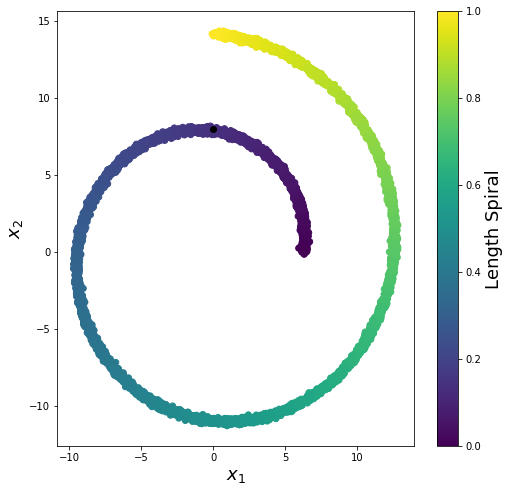

In [10]:
fig, ax = data.plot()
cp = ax.scatter(x_explain[0], x_explain[1], c='black')
color = plt.colorbar(cp)
fig.set_size_inches(8,8)
color.set_label(label='Length Spiral', size=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)

In [11]:
rf.predict(np.array([[0.0, 8.0]]))-rf.predict(np.array([[1.0, 8.0]]))

array([0.93432842])

### Normal Lime

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train, feature_names=data.feature_names,
    class_names=['price'], categorical_features=categorical_features,
    verbose=True, mode='regression', discretize_continuous=False)

In [13]:
exp = explainer.explain_instance(
    x_explain,
    rf.predict, num_features=5,
    model_regressor=Linear()
    )

Intercept 47.85800434930353
Prediction_local [53.10418475]
Right: 32.50295513116682


The Prediction_local and Right do not agree, decreasing the user trust in the produced interpretation.

In [14]:
exp.show_in_notebook(show_table=True)

This explanation is not correct, the x<sub>2</sub> is given as the most important feature. 


### m-lime using KDEGen

Now, we use Kernel Density Estimation (KDE) to obtain an estimative of the manifold of the feature space. Then, the interpretation is produced from samples drawn from this estimative close from the instance x<sup>1</sup>

In [15]:
explainer_mani = LimeTabularExplainerManifold(
    x_train, sample_around_instance=True, manifold='kde'
    , feature_names=data.feature_names, class_names=['price']
    , categorical_features=categorical_features
    , verbose=True, mode='regression'
    , discretize_continuous=False
    , manifold_params={'search_best': True})
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict, num_features=5
    , r_density=0.1, model_regressor=Linear(), scale_data=False)

Best Parameter for the KDE:
{'bandwidth': 0.005}
Score: 308.6714849284258
Intercept 31.10344953009622
Prediction_local [32.51072471]
Right: 32.50295513116682


In [16]:
exp_mani.show_in_notebook(show_table=True)

In [17]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict, num_features=5
    , r_density=0.1, model_regressor=Linear(), scale_data=False)

Intercept 31.08017103491098
Prediction_local [32.51344611]
Right: 32.50295513116682


The Prediction_local and Right have a good agreement, increasing the user trust in the produced interpretation.

#### Visualization of the sampled data:

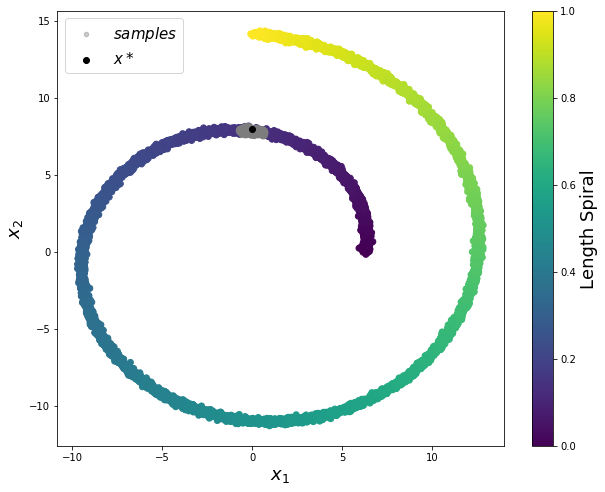

In [18]:
fig, ax = data.plot()
cp = ax.scatter(explainer_mani.data[:, 0], explainer_mani.data[:, 1], s=20, c='tab:gray', alpha=0.4, label='$samples$')
cp = ax.scatter(x_explain[0], x_explain[1], c='black', label='$x*$')
color = plt.colorbar(cp)
fig.set_size_inches(10,8)
color.set_label(label='Length Spiral', size=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.legend(fontsize=15)

This results show the importance the importance to correct define the neigbordhood to produce meaninful intepretation for a instance.

In [19]:
from m_lime.explainers.explainer_linear import ExplainerLinear
from m_lime.generators.kde_gen import KDEGen
from m_lime.explainers.visualizations.plot_importance import ExplainGraph

In [20]:
density = KDEGen(kernel='gaussian', bandwidth=0.1, search_best=True).fit(x_train)

Best Parameter for the KDE:
{'bandwidth': 0.08315789473684211}
Score: -5720.914770338754


In [81]:
explainer, explanation, cov_fav_examples = None, None, None
def explainer_linear(x_explain, local_model, tol=0.03):
    explainer = ExplainerLinear(
        model_predict=rf.predict,
        density=density,
        local_model=local_model,
        feature_names=['$x_1$', '$x_2$'],
        transformer=None,
        verbose=False
    )
    explanation, cov_fav_examples, local_model = explainer.explain_instance(
            x_explain=x_explain.reshape(1, -1),
            r=0.5,
            n_samples=5000,
            tol=tol,
            local_mini_batch_max=100,
            weight_kernel='gaussian'
          )
    return explanation, cov_fav_examples, local_model, explainer

## HuberRegressor

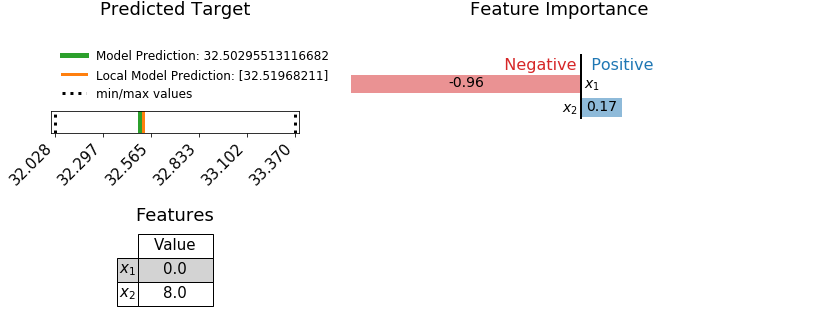

In [82]:
explanation, cov_fav_examples, local_model, explainer = explainer_linear(x_explain, 'HuberRegressor')
fig, axs = ExplainGraph.plot(local_model.explain())

## Ridge

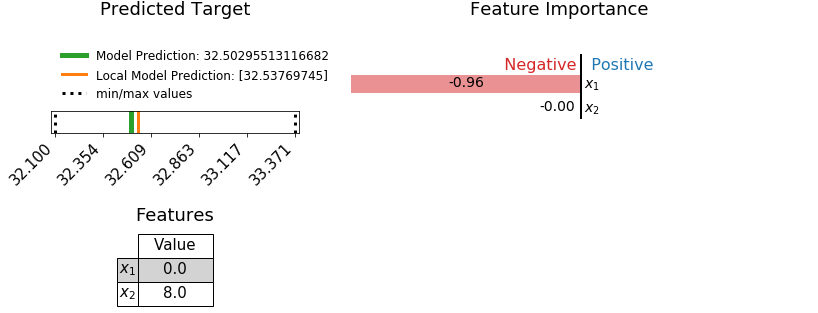

In [83]:
explanation, cov_fav_examples, local_model, explainer= explainer_linear(x_explain, 'Ridge')
fig, axs = ExplainGraph.plot(local_model.explain())

../m_lime/explainers/explainer.py:162: UserWarning: Convergence tolerance (tol) was not achieved!
Current difference in the importance None/0.03
Current Error: 0.133856964574118/0.03
  "Convergence tolerance (tol) was not achieved!\n"


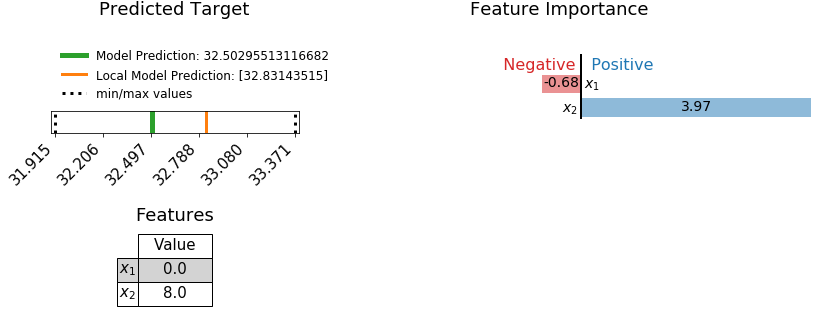

In [84]:
explanation, cov_fav_examples, local_model, explainer= explainer_linear(x_explain, 'SGD')
fig, axs = ExplainGraph.plot(local_model.explain())